In [1]:
## Preliminary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV

!pip install mitosheet 
import mitosheet 

!pip install xgboost
import xgboost

%config InlineBackend.figure_format = "svg"

In [3]:
df = pd.read_csv('../datasets/train.csv')

In [4]:
# Remove irrelevant columns

In [5]:
# Deleted columns property_id
df.drop(['property_id'], axis=1, inplace=True)

# Deleted columns property_name
df.drop(['property_name'], axis=1, inplace=True)

# Deleted columns property_summary
df.drop(['property_summary'], axis=1, inplace=True)

# Deleted columns property_space
df.drop(['property_space'], axis=1, inplace=True)

# Deleted columns property_desc
df.drop(['property_desc'], axis=1, inplace=True)

# Deleted columns property_neighborhood
df.drop(['property_neighborhood'], axis=1, inplace=True)

# Deleted columns property_notes
df.drop(['property_notes'], axis=1, inplace=True)

# Deleted columns property_transit
df.drop(['property_transit'], axis=1, inplace=True)

# Deleted columns property_access
df.drop(['property_access'], axis=1, inplace=True)

# Deleted columns property_interaction
df.drop(['property_interaction'], axis=1, inplace=True)

# Deleted columns property_rules
df.drop(['property_rules'], axis=1, inplace=True)

# Deleted columns property_sqfeet
df.drop(['property_sqfeet'], axis=1, inplace=True)

# Deleted columns property_scraped_at
df.drop(['property_scraped_at'], axis=1, inplace=True)

# Deleted columns property_last_updated
df.drop(['property_last_updated'], axis=1, inplace=True)

# Deleted columns host_id
df.drop(['host_id'], axis=1, inplace=True)

# Deleted columns host_location
df.drop(['host_location'], axis=1, inplace=True)

# Deleted columns host_about
df.drop(['host_about'], axis=1, inplace=True)

# Deleted columns host_nr_listings_total
df.drop(['host_nr_listings_total'], axis=1, inplace=True)

# Deleted columns host_verified
df.drop(['host_verified'], axis=1, inplace=True)

# Deleted columns booking_max_nights
df.drop(['booking_max_nights'], axis=1, inplace=True)

# Deleted columns reviews_first
df.drop(['reviews_first'], axis=1, inplace=True)

# Deleted columns reviews_last
df.drop(['reviews_last'], axis=1, inplace=True)

In [6]:
# Transform target to logarithm (target)
df['target'] = np.log(df['target'])

In [7]:
# Remove target outliers
Q1_target = df['target'].quantile(0.25)
Q3_target = df['target'].quantile(0.75)
IQR_target = Q3_target - Q1_target

lower_bound_target = Q1_target - 1.5 * IQR_target
upper_bound_target = Q3_target + 1.5 * IQR_target

df = df[(df['target'] >= lower_bound_target) & (df['target'] <= upper_bound_target)]

In [8]:
# Check for missing values
df['property_lon'].isna().sum()

0

In [9]:
# Check for missing values
df['property_lat'].isna().sum()

0

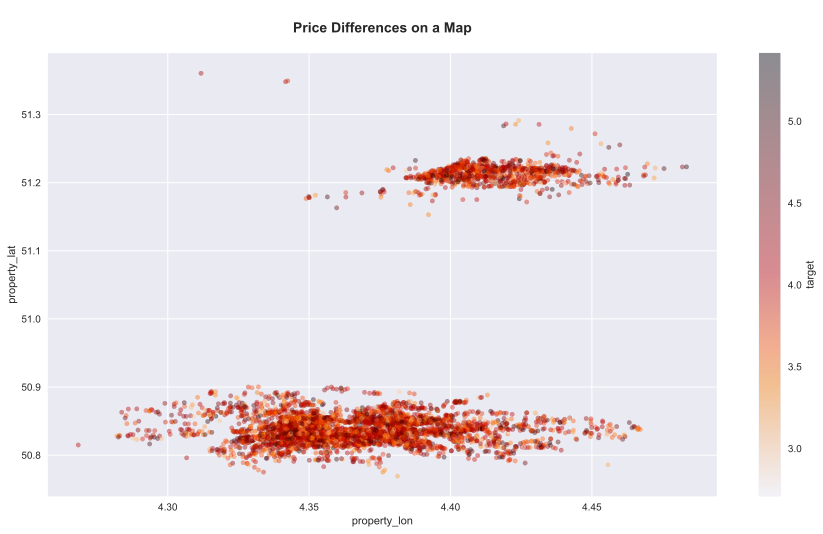

In [10]:
# Plot price differences on coordinates
df.plot(kind="scatter", x="property_lon", y="property_lat", alpha=0.4,
        c="target", cmap="gist_heat_r", colorbar=True, sharex=False, figsize=(15,8));
plt.title('\nPrice Differences on a Map\n', fontsize=14, fontweight='bold');

In [11]:
# Calculate the distance to the center of Brussels for all properties with zipcode 1
from geopy import distance

# Coordinates of the center of Brussels
brussels_lat = 50.8503
brussels_lon = 4.3517

# Clean property_zipcode
df.dropna(subset=['property_zipcode'], inplace=True)

# Filter properties with zip code starting with '1'
zip1_df = df[df['property_zipcode'].str.startswith('1')]

# Calculate distance from each property to center of Brussels using geopy.distance
distances_brussels = zip1_df.apply(lambda row: distance.distance((row['property_lat'], row['property_lon']), (brussels_lat, brussels_lon)).km, axis=1)

# Add the distances as a new column in the DataFrame
zip1_df['distance_to_brussels'] = distances_brussels

/var/folders/br/y1wjgh1n2xxdt0ghw8bn5r_00000gn/T/ipykernel_82450/1289912194.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip1_df['distance_to_brussels'] = distances_brussels


In [12]:
# Remove outliers in terms of distance to Brussels
# Idea: a property might be too distant

# Calculate the IQR for the distances
Q1_d_Br = np.percentile(zip1_df['distance_to_brussels'], 25)
Q3_d_Br = np.percentile(zip1_df['distance_to_brussels'], 75)
IQR_d_Br = Q3_d_Br - Q1_d_Br

# Filter out any properties with distances outside of the IQR
zip1_df_filtered = zip1_df[(zip1_df['distance_to_brussels'] >= Q1_d_Br - 1.5*IQR_d_Br) & (zip1_df['distance_to_brussels'] <= Q3_d_Br + 1.5*IQR_d_Br)]

In [13]:
# Test correlation between distance_to_brussels and target

correlation = zip1_df_filtered['target'].corr(zip1_df_filtered['distance_to_brussels'])
print(correlation)

-0.0007632945579050253


In [14]:
from scipy.stats import pearsonr

# Calculate correlation and p-value
corr, pval = pearsonr(zip1_df_filtered['distance_to_brussels'], zip1_df_filtered['target'])

# Print results
print("Correlation between distance to center of Brussels and target price: {:.2f}".format(corr))
print("P-value: {:.4f}".format(pval))

if pval < 0.05:
    print("The correlation is statistically significant at the 0.05 level.")
else:
    print("The correlation is not statistically significant at the 0.05 level.")


Correlation between distance to center of Brussels and target price: -0.00
P-value: 0.9567
The correlation is not statistically significant at the 0.05 level.


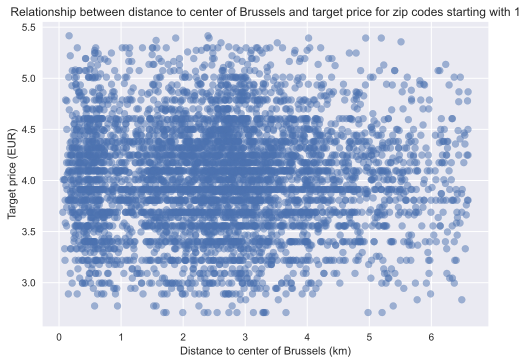

In [15]:
# Create scatter plot
plt.scatter(zip1_df_filtered['distance_to_brussels'], zip1_df_filtered['target'], alpha=0.5)

# Add axis labels and title
plt.xlabel('Distance to center of Brussels (km)')
plt.ylabel('Target price (EUR)')
plt.title('Relationship between distance to center of Brussels and target price for zip codes starting with 1')

# Show plot
plt.show()

In [16]:
# Calculate the distance to the center of Antwerp for all properties with zipcode 2
from geopy import distance

# Coordinates of the center of Brussels
antwerp_lat = 51.2199
antwerp_lon = 4.3963

# Filter properties with zip code starting with '1'
zip2_df = df[df['property_zipcode'].str.startswith('2')]

# Calculate distance from each property to center of Brussels using geopy.distance
distances_antwerp = zip2_df.apply(lambda row: distance.distance((row['property_lat'], row['property_lon']), (antwerp_lat, antwerp_lon)).km, axis=1)

# Add the distances as a new column in the DataFrame
zip2_df['distance_to_antwerp'] = distances_antwerp

/var/folders/br/y1wjgh1n2xxdt0ghw8bn5r_00000gn/T/ipykernel_82450/1165955685.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip2_df['distance_to_antwerp'] = distances_antwerp


In [17]:
distances_antwerp

1       3.052799
2       3.181688
3       0.639576
4       0.648721
14      0.864814
          ...   
6464    2.971286
6467    0.810811
6471    0.205670
6492    2.567057
6494    2.700396
Length: 1064, dtype: float64

In [18]:
# Remove outliers in terms of distance to Antwerp
# Idea: a property might be too distant

# Calculate the IQR for the distances
Q1_d_An = np.percentile(zip2_df['distance_to_antwerp'], 25)
Q3_d_An = np.percentile(zip2_df['distance_to_antwerp'], 75)
IQR_d_An = Q3_d_An - Q1_d_An

# Filter out any properties with distances outside of the IQR
zip2_df_filtered = zip2_df[(zip2_df['distance_to_antwerp'] >= Q1_d_An - 1.5*IQR_d_An) & (zip2_df['distance_to_antwerp'] <= Q3_d_An + 1.5*IQR_d_An)]

In [19]:
# Test correlation between distance_to_brussels and target

correlation1 = zip2_df_filtered['target'].corr(zip2_df_filtered['distance_to_antwerp'])
print(correlation1)

-0.031192333011115448


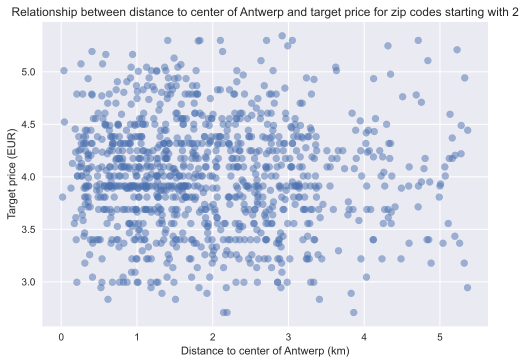

In [20]:
# Create scatter plot
plt.scatter(zip2_df_filtered['distance_to_antwerp'], zip2_df_filtered['target'], alpha=0.5)

# Add axis labels and title
plt.xlabel('Distance to center of Antwerp (km)')
plt.ylabel('Target price (EUR)')
plt.title('Relationship between distance to center of Antwerp and target price for zip codes starting with 2')

# Show plot
plt.show()

In [21]:
from scipy.stats import pearsonr

# Calculate correlation and p-value
corr, pval = pearsonr(zip2_df_filtered['distance_to_antwerp'], zip2_df_filtered['target'])

# Print results
print("Correlation between distance to center of Antwerp and target price: {:.2f}".format(corr))
print("P-value: {:.4f}".format(pval))

if pval < 0.05:
    print("The correlation is statistically significant at the 0.05 level.")
else:
    print("The correlation is not statistically significant at the 0.05 level.")


Correlation between distance to center of Antwerp and target price: -0.03
P-value: 0.3147
The correlation is not statistically significant at the 0.05 level.


In [22]:
# Because of the reasons highlighted in this EDA, we have decided to remove property_lon and property_lat
# as an attribute from our training set.